In [132]:
import torch
from names_dataset import NameDataset
import re
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
%matplotlib inline

In [2]:
SEED = 42

# Data

In [3]:
nd = NameDataset()

In [4]:
country_codes = ["US", "CA", "GB", "IN"]            # USA, Canada, Great Britain, India

In [5]:
dataset = set()
dataset_size = 50000
for code in country_codes:
    data = nd.get_top_names(n=dataset_size, country_alpha2=code)
    dataset.update(set(data[code]['M'] + data[code]['F']))

In [6]:
len(dataset)

43231

In [7]:
# clean and make each name 1 word
names = list()
for name in dataset:
    if re.match(r"^[A-Za-z\s]+$", name):            # only consider names with english alphabets
        for i in name.split():
            if len(i)>1: names.append(i.lower())

In [8]:
chars = sorted(list(set(''.join(names))))
ctoi = {k:idx+1 for idx, k in enumerate(chars)}
ctoi['.'] = 0
itoc = {v:k for k,v in ctoi.items()}

In [9]:
print(ctoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


# Multi Layer Perceptron
implementation of (Bengio et al. 2003 Neural Probabilistic LM paper)[https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf]

![Neural Probabilistic LM](images/neural_prob_LM.png)


### Dataset

In [10]:
context_length = 3  # block size
x, y = [], []
for name in names:
    # print(name)
    context = [0] * context_length
    for c in name + '.':
        idx = ctoi[c]
        x.append(context)
        y.append(idx)
        # print(''.join([itoc[i] for i in context]), '------>', itoc[idx])
        context = context[1:] + [idx]

x = torch.tensor(x)
y = torch.tensor(y)

In [11]:
x[:5], y[:5]

(tensor([[ 0,  0,  0],
         [ 0,  0, 14],
         [ 0, 14,  5],
         [14,  5,  7],
         [ 5,  7, 26]]),
 tensor([14,  5,  7, 26, 26]))

### Embedding (lookup)

In [12]:
# Let's create a 2 dimensional lookup for the 27 chars we have
C = torch.randn((27,2))

In [13]:
C[5]

tensor([ 0.1850, -1.9612])

In [14]:
F.one_hot(torch.tensor(5), num_classes=27).float()@C

tensor([ 0.1850, -1.9612])

In [15]:
C[[3,4,5]]

tensor([[ 0.4619, -0.7100],
        [-1.0147,  0.2709],
        [ 0.1850, -1.9612]])

In [16]:
x[:4]

tensor([[ 0,  0,  0],
        [ 0,  0, 14],
        [ 0, 14,  5],
        [14,  5,  7]])

In [17]:
x[:4].shape

torch.Size([4, 3])

In [18]:
C[x[:4]]

tensor([[[ 1.3335,  1.1781],
         [ 1.3335,  1.1781],
         [ 1.3335,  1.1781]],

        [[ 1.3335,  1.1781],
         [ 1.3335,  1.1781],
         [ 0.7193, -0.4586]],

        [[ 1.3335,  1.1781],
         [ 0.7193, -0.4586],
         [ 0.1850, -1.9612]],

        [[ 0.7193, -0.4586],
         [ 0.1850, -1.9612],
         [ 0.2678, -1.6484]]])

In [19]:
C[x[:4]].shape

torch.Size([4, 3, 2])

In [20]:
emb = C[x]
emb.shape

torch.Size([306991, 3, 2])

## neural network

### detail

In [21]:
sample = x[:5]
sample.shape

torch.Size([5, 3])

In [22]:
# input to the model will be embeddings of the input
model_inp = C[sample]
model_inp.shape

torch.Size([5, 3, 2])

Here the shape is ==> batch_size * context_len * embed_dim. That means, for each sample, the input shape fed to the nn is context_len * embed_dim (eg. 3*2)

Let's create an input layer that has context_len * embed_dim neurons and 100 neurons in the hidden layer.

In [23]:
W1 = torch.randn((6,100))
b1 = torch.randn((100))

In [24]:
# we have to do Wx+b for each sample. but we can't as shown below
model_inp @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (15x2 and 6x100)

The error is because we cannot do matrix multiplication for 5x3x2 and 6x100. We have to concatenate all the dimensions for each input sample.

i.e, we have to convert 5x3x2 to 5x6.

There are multiple ways to do this but the most efficient(space & time) is torch has view() that doesn't create a new tensor but changes the dimension using the same memory.

In [25]:
model_inp

tensor([[[ 1.3335,  1.1781],
         [ 1.3335,  1.1781],
         [ 1.3335,  1.1781]],

        [[ 1.3335,  1.1781],
         [ 1.3335,  1.1781],
         [ 0.7193, -0.4586]],

        [[ 1.3335,  1.1781],
         [ 0.7193, -0.4586],
         [ 0.1850, -1.9612]],

        [[ 0.7193, -0.4586],
         [ 0.1850, -1.9612],
         [ 0.2678, -1.6484]],

        [[ 0.1850, -1.9612],
         [ 0.2678, -1.6484],
         [ 0.4222,  0.8013]]])

In [26]:
# one naive way -
torch.cat([model_inp[:, 0, :], model_inp[:, 1, :], model_inp[:, 2, :]], 1)

tensor([[ 1.3335,  1.1781,  1.3335,  1.1781,  1.3335,  1.1781],
        [ 1.3335,  1.1781,  1.3335,  1.1781,  0.7193, -0.4586],
        [ 1.3335,  1.1781,  0.7193, -0.4586,  0.1850, -1.9612],
        [ 0.7193, -0.4586,  0.1850, -1.9612,  0.2678, -1.6484],
        [ 0.1850, -1.9612,  0.2678, -1.6484,  0.4222,  0.8013]])

In [27]:
# another way -
torch.cat(torch.unbind(model_inp, 1), 1)

tensor([[ 1.3335,  1.1781,  1.3335,  1.1781,  1.3335,  1.1781],
        [ 1.3335,  1.1781,  1.3335,  1.1781,  0.7193, -0.4586],
        [ 1.3335,  1.1781,  0.7193, -0.4586,  0.1850, -1.9612],
        [ 0.7193, -0.4586,  0.1850, -1.9612,  0.2678, -1.6484],
        [ 0.1850, -1.9612,  0.2678, -1.6484,  0.4222,  0.8013]])

In [28]:
# but the efficient way -
model_inp.view((5,6))

tensor([[ 1.3335,  1.1781,  1.3335,  1.1781,  1.3335,  1.1781],
        [ 1.3335,  1.1781,  1.3335,  1.1781,  0.7193, -0.4586],
        [ 1.3335,  1.1781,  0.7193, -0.4586,  0.1850, -1.9612],
        [ 0.7193, -0.4586,  0.1850, -1.9612,  0.2678, -1.6484],
        [ 0.1850, -1.9612,  0.2678, -1.6484,  0.4222,  0.8013]])

In [29]:
## view's efficiency as long as total elements are same
a = torch.arange(24)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23])

In [30]:
a.view((12,2))

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17],
        [18, 19],
        [20, 21],
        [22, 23]])

In [31]:
a.view((4,3,2))

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]],

        [[18, 19],
         [20, 21],
         [22, 23]]])

In [32]:
a.view((2,2,3,2))

tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]],

         [[ 6,  7],
          [ 8,  9],
          [10, 11]]],


        [[[12, 13],
          [14, 15],
          [16, 17]],

         [[18, 19],
          [20, 21],
          [22, 23]]]])

In [33]:
# always stored as 1-d array in memory. But view gives us in the required shape by indexing
a.storage()

/var/folders/7v/p6dm1_f165zdwds1rtz7sw080000gn/T/ipykernel_10808/3775447253.py:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 24]

Now this can be input to the nn layer with 6 neurons(inputs).

In [34]:
# properly multiply to get hidden states
(model_inp.view((5,6)) @ W1 + b1).shape     # (5x6) @ (6x100) -> (5x100) - 100 dim activations of our 5 examples

torch.Size([5, 100])

In [35]:
h1 = torch.tanh(model_inp.view((-1,6)) @ W1 + b1)       # 1)if -1, torch will infer. 2) tanh activation as used in the paper

Let's create output layer with 27 neurons because we have 27 characters

In [36]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27))

In [37]:
logits = h1 @ W2 + b2

In [38]:
logits.shape        # each input sample with log counts for each character out of which one has to be predicted

torch.Size([5, 27])

In [39]:
counts = logits.exp()

In [40]:
probs = counts/counts.sum(dim=1, keepdim=True)

In [41]:
probs.shape

torch.Size([5, 27])

In [42]:
probs[0].sum()

tensor(1.)

In [43]:
Y = y[:5]
Y       # actual/gold output

tensor([14,  5,  7, 26, 26])

In [44]:
pred_probs = probs[torch.arange(5), Y]
pred_probs

tensor([3.9265e-06, 1.0256e-10, 7.7295e-13, 1.2179e-05, 1.8512e-05])

In [45]:
loss = -probs[torch.arange(5), Y].log().mean()      # nll loss
loss

tensor(17.1099)

In [46]:
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)           # total parameters of this network

3481

In [47]:
counts = logits.exp()
probs = counts/counts.sum(dim=1, keepdim=True)
loss = -probs[torch.arange(5), y[:5]].log().mean()      # nll loss
loss

tensor(17.1099)

In [48]:
# torch has an efficient implementation of calculating the above classification loss - F.cross_entropy
F.cross_entropy(logits, y[:5])

tensor(17.1099)

In [49]:
# reason - 1 for effieciency -> torch calculates cross_entropy in fused kernels that makes broadcasted computation, no use of extra memory => both forward and backward passes are much more efficient
# reason - 2 -> cross entropy is numerically well behaved , below is an example
logits = torch.tensor([-2,-3,0,3])      # all good for normal values
counts = logits.exp()
probs = counts/counts.sum()
probs

tensor([0.0064, 0.0023, 0.0470, 0.9443])

In [50]:
logits = torch.tensor([-2,-300,0,3])      # all good for extreme -ve values
counts = logits.exp()
probs = counts/counts.sum()
probs

tensor([0.0064, 0.0000, 0.0471, 0.9465])

In [51]:
logits = torch.tensor([-2,-300,0,300])      # crashes for extreme +ve values (which are not uncommon in training)
counts = logits.exp()
probs = counts/counts.sum()
probs

tensor([0., 0., 0., nan])

In [52]:
counts          # we got infinity here because of the way exp() works

tensor([0.1353, 0.0000, 1.0000,    inf])

In [53]:
logits = torch.tensor([-2,-300,0,300]) - 300      # subtract the max number
counts = logits.exp()
probs = counts/counts.sum()
probs

tensor([0., 0., 0., 1.])

In [54]:
counts

tensor([0., 0., 0., 1.])

In [55]:
# for training (backward pass), we need gradients
for p in parameters:
    p.requires_grad = True

In [56]:
# training loop
def train(epochs, batch_size):
    for _ in range(epochs):
        # forward pass
        emb = C[x[:batch_size]]
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, y[:batch_size])
        print(loss.item())
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # update parameters
        lr = 0.1
        for p in parameters:
            p.data += -lr * p.grad

In [57]:
train(10, 32)

14.757530212402344
12.442512512207031
10.501753807067871
8.920267105102539
7.649085521697998
6.697340488433838
5.959523677825928
5.341253280639648
4.804412841796875
4.332081317901611


In [58]:
# same training loop without print at each epoch but at the end
def train(epochs, batch_size):
    for _ in range(epochs):
        # forward pass
        emb = C[x[:batch_size]]
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, y[:batch_size])
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # update parameters
        lr = 0.1
        for p in parameters:
            p.data += -lr * p.grad
    print(loss.item())

In [67]:
train(100, 32)      ## currently overfitting b/c we're training only for 32 (one batch) examples and have 3481 parameters. (parameters >> training samples)

0.17777201533317566


### training implementation

In [68]:
x.shape, y.shape

(torch.Size([306991, 3]), torch.Size([306991]))

In [107]:
## init model

g = torch.Generator().manual_seed(SEED)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

print(f"total number of parameters {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True  

total number of parameters 3481


In [75]:
def train(epochs=10):
    for _ in range(epochs):
        # forward pass
        emb = C[x]
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, y)
        print(loss.item())
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # update parameters
        lr = 0.1
        for p in parameters:
            p.data += -lr * p.grad

In [76]:
train(10)       ## taking more time for each epoch since we're doing forward and backward for whole training data, so let's do batched training(minibatches)

17.017581939697266
15.313886642456055
14.293935775756836
13.460793495178223
12.73753547668457
12.160568237304688
11.671038627624512
11.240046501159668
10.853802680969238
10.510765075683594


In [77]:
# we can create minibatch by selecting <batch_size> examples randomly from the training data
batch_size = 32
torch.randint(0, 10, (batch_size,)) # this gives 32 numbers(indices in our case) from [0, 10)

tensor([3, 8, 7, 1, 2, 6, 7, 4, 8, 8, 0, 6, 2, 0, 3, 8, 1, 1, 0, 7, 6, 4, 1, 5,
        4, 6, 5, 1, 7, 3, 8, 3])

In [78]:
# let's select indices for out training dataset length so that we can index from the training data
torch.randint(0, x.shape[0], (batch_size,))

tensor([209112, 201644,   6384, 189524, 238167, 203028, 219821, 207094, 235797,
         10486, 218455, 220636, 142283, 239068, 283682, 244342, 277440,  77385,
        256171, 186102, 280516,  48286, 253093, 150152, 179557, 131852, 265752,
         19167, 137553,  44667,  19784, 217942])

In [79]:
x[torch.randint(0, x.shape[0], (batch_size,))].shape

torch.Size([32, 3])

In [83]:
# let's do minibatch training
def train(steps=10, batch_size=32):
    for _ in range(steps):
        # minibatch
        ix = torch.randint(0, x.shape[0], (batch_size,))
        # forward pass
        emb = C[x[ix]]
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, y[ix])
        # print(loss.item())
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # update parameters
        lr = 0.1
        for p in parameters:
            p.data += -lr * p.grad
    print(loss.item())

In [81]:
train(10, 32)   # much faster, but the gradient may not be reliable because of the fluctuations. But it works over the entire training data emperically since the direction of the gradient will be to the minimum though it fluctuates

9.95998764038086
10.172564506530762
9.74691104888916
9.980635643005371
8.728821754455566
8.889914512634277
9.491644859313965
10.418598175048828
7.901980400085449
9.502591133117676


In [82]:
# calculate loss for the entire training set
emb = C[x]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y)
print(loss.item())

8.306142807006836


In [92]:
train(1000, 32)     # commented print in train for loop 

2.7768492698669434


In [93]:
# calculate loss for the entire training set
emb = C[x]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y)
print(loss.item())

2.5457804203033447


Let's determine the good learning rate

In [111]:
# reset parameters

g = torch.Generator().manual_seed(SEED)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

print(f"total number of parameters {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True  

total number of parameters 3481


In [112]:
lre = torch.linspace(-3, 0, 1000)   # 1000 linearly spaced numbers b/w -3 and 0, these are used as exponents
lrs = 10**lre       # we get 1000 values from 0.001 and 1 stepped exponentially  
len(lrs)

1000

In [113]:
lri = []
lossi = []
for i in range(1000):       # same number of steps as lrs
    # minibatch
    ix = torch.randint(0, x.shape[0], (batch_size,))
    # forward pass
    emb = C[x[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update parameters
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())
    

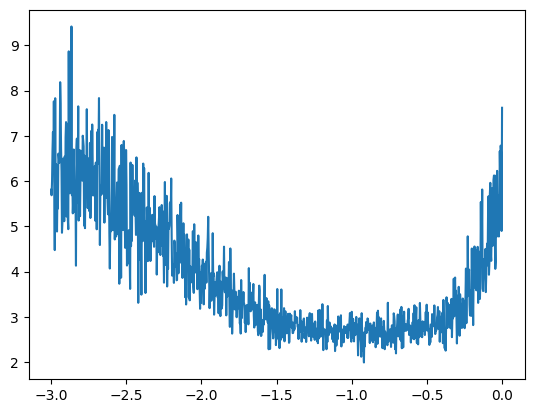

In [114]:
plt.plot(lri, lossi)

from the plot, lre ~ -1 is good enough. so lr = 10**-1 = 0.1 is good, what we took initially is good :-)

In [115]:
# let's train with this learning rate
## init model

g = torch.Generator().manual_seed(SEED)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

print(f"total number of parameters {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True  

total number of parameters 3481


In [116]:
lr = 0.1

In [117]:
# let's do minibatch training
def train(steps=10, batch_size=32, lr=0.1):
    for _ in range(steps):
        # minibatch
        ix = torch.randint(0, x.shape[0], (batch_size,))
        # forward pass
        emb = C[x[ix]]
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, y[ix])
        # print(loss.item())
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # update parameters
        for p in parameters:
            p.data += -lr * p.grad

In [118]:
def calc_overall_loss():
    # calculate loss for the entire training set
    emb = C[x]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(loss.item())

In [119]:
# let's train for 10,000 steps
train(10000, 32, 0.1)

In [120]:
calc_overall_loss()

2.4817726612091064


In [121]:
# let's train for another 10,000 steps
train(10000, 32, 0.1)
calc_overall_loss()

2.448557138442993


In [127]:
# let's train for one more 10,000 steps
train(10000, 32, 0.1)
calc_overall_loss()

2.4298393726348877


surpassed the performance of the bigram model in the previous notebook 🥳

In [128]:
# let's decay the learning rate by 10%. at the end of the training, we can reduce the lr to take tiny steps to minima
# let's train for another 10,000 steps
train(10000, 32, 0.01)
calc_overall_loss()

2.3766236305236816


In [129]:
# let's train again for another 10,000 steps
train(10000, 32, 0.01)
calc_overall_loss()

2.3752195835113525


In [130]:
# one more
train(10000, 32, 0.01)
calc_overall_loss()

2.3739705085754395


we don't know whether we're actually improving or overfitting here. So let's divide the data into train, dev and test splits

train set - tune model parameters

dev set - tune hyperparameters

test set - estimate actual perf, use very sparingly

In [133]:
def build_dataset(names):
    context_length = 3  # block size
    x, y = [], []
    for name in names:
        # print(name)
        context = [0] * context_length
        for c in name + '.':
            idx = ctoi[c]
            x.append(context)
            y.append(idx)
            # print(''.join([itoc[i] for i in context]), '------>', itoc[idx])
            context = context[1:] + [idx]

    x = torch.tensor(x)
    y = torch.tensor(y)
    return x, y
random.seed(SEED)
random.shuffle(names)
n1, n2 = int(0.8*len(names)), int(0.9*len(names))
x_tr, y_tr = build_dataset(names[: n1])
x_dev, y_dev = build_dataset(names[n1: n2])
x_test, y_test = build_dataset(names[n2:])

In [134]:
len(x_tr), len(x_dev), len(x_test)

(245708, 30505, 30778)

In [153]:
# let's train with this learning rate
## init model

g = torch.Generator().manual_seed(SEED)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

print(f"total number of parameters {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True  

total number of parameters 3481


In [154]:
# let's do minibatch training
def train(steps=10, batch_size=32, lr=0.1):
    for _ in range(steps):
        # minibatch
        ix = torch.randint(0, x_tr.shape[0], (batch_size,))
        # forward pass
        emb = C[x_tr[ix]]
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, y_tr[ix])
        # print(loss.item())
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # update parameters
        for p in parameters:
            p.data += -lr * p.grad

In [155]:
def calc_overall_loss(x=x_dev, y=y_dev):
    # calculate loss for the entire training set
    emb = C[x]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(loss.item())

In [156]:
# let's train for 10,000 steps
train(30000, 32, 0.1)
calc_overall_loss()

2.4018607139587402


In [157]:
train(10000, 32, 0.01)
calc_overall_loss()      # good enough on dev

2.336449384689331


In [158]:
calc_overall_loss(x_tr, y_tr)   # calc loss on train set

2.327794313430786


our train and dev are almost equal, so we're not overfitting. But we're underfitting, i.e, our nn is tiny and we can expect perf improvement by scaling up size of nn

In [193]:
## init large model

g = torch.Generator().manual_seed(SEED)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

print(f"total number of parameters {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True   

total number of parameters 10281


now we have >10k parameters

In [194]:
# let's do minibatch training and return history/stats
def train(steps=10, batch_size=32, lr=0.1):
    lossi = []
    stepsi = []
    for i in range(steps):
        # minibatch
        ix = torch.randint(0, x_tr.shape[0], (batch_size,))
        # forward pass
        emb = C[x_tr[ix]]
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, y_tr[ix])
        # print(loss.item())
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # update parameters
        for p in parameters:
            p.data += -lr * p.grad
        
        # track stats
        lossi.append(loss.item())
        stepsi.append(i)
    return stepsi, lossi

In [195]:
steps, loss = train(30000, 32, 0.1)
calc_overall_loss()

2.593662738800049


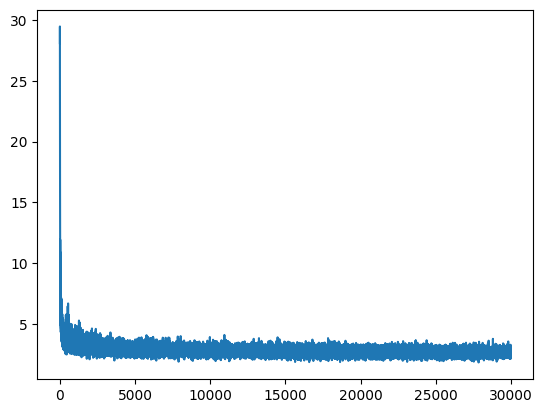

In [196]:
plt.plot(steps, loss)

the line got thicker because there are lot of fluctuations b/c of minibatches, one way to improve the gradient/model is to increase the batch size so that we get good loss without crazy fluctuations

In [197]:
# let's train more
steps, loss = train(30000, 32, 0.1)
calc_overall_loss()

2.534715175628662


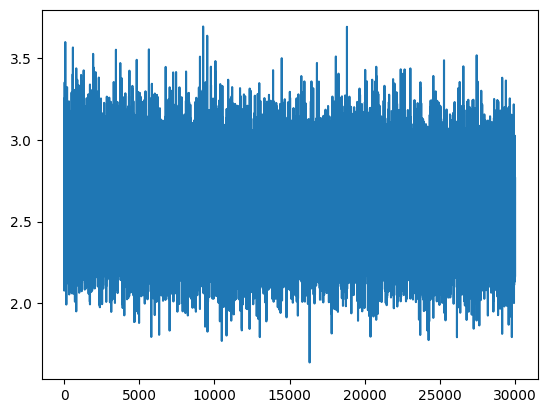

In [198]:
# this will be meaningless as we overwritten the prev stuff
plt.plot(steps, loss)

maybe decreasing but not obvious

In [199]:
# let's train more
steps, loss = train(30000, 32, 0.05) # let's half the lr
calc_overall_loss()

2.4361770153045654


In [200]:
# let's train once more
steps, loss = train(30000, 32, 0.05)
calc_overall_loss()

2.426591634750366


In [201]:
# let's train once more
steps, loss = train(30000, 32, 0.05)
calc_overall_loss()

2.4180502891540527


In [202]:
# let's train once more
steps, loss = train(30000, 32, 0.05)
calc_overall_loss()

2.4179487228393555


In [203]:
# let's train more
steps, loss = train(30000, 32, 0.01)        # reduce lr
calc_overall_loss()

2.3454651832580566


In [204]:
# let's train once more
steps, loss = train(30000, 32, 0.01)
calc_overall_loss()

2.344560146331787


In [209]:
# let's train more
steps, loss = train(30000, 32, 0.01)
calc_overall_loss()

2.342893362045288


In [210]:
calc_overall_loss(x_tr, y_tr)

2.3295812606811523


Model is trying to overfit and not improve on dev set. This can be b/c we have lot of parameters and we're cramming all the characters to 2 dimensional and this may not be enough for the model to converge and increasing the embedding dimension may improve the performance

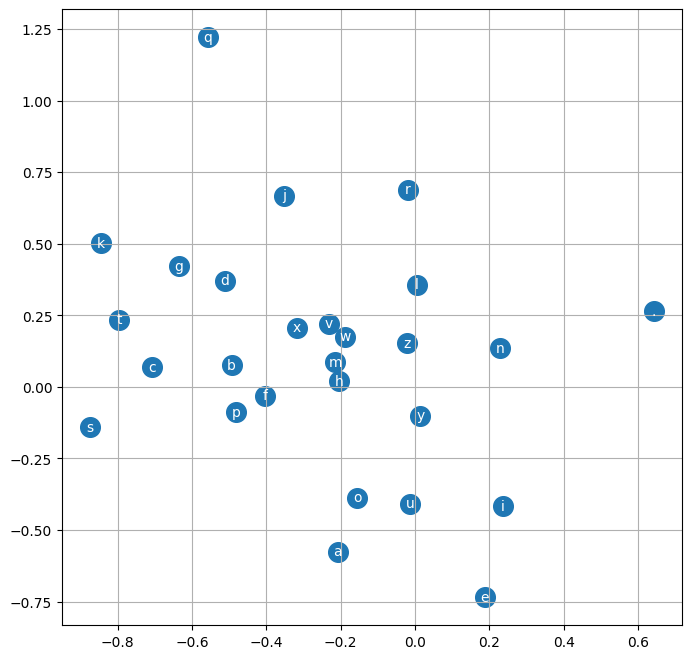

In [211]:
# let's visualize the embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color="white")
plt.grid("minor")

nn is trying to cluster and seperate the characters. 

eg. 

1) vowels are roughly clustered

2) '.' and 'q' are outliers etc

so this is definitely not random

since we're not improving even after increasing the model size, let's increase the embedding size and check the results

In [219]:
## init large model

g = torch.Generator().manual_seed(SEED)
C = torch.randn((27,10), generator=g)       # take embed size as 10
W1 = torch.randn((30, 200), generator=g)    # let's reduce the hidden layer 
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

print(f"total number of parameters {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True   

total number of parameters 11897


now we have >11k parameters

In [220]:
lossi = []
stepsi = []

In [221]:
# let's do minibatch training and return history/stats
def train(steps=10, batch_size=32, lr=0.1):
    for i in range(steps):
        # minibatch
        ix = torch.randint(0, x_tr.shape[0], (batch_size,))
        # forward pass
        emb = C[x_tr[ix]]
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, y_tr[ix])
        # print(loss.item())
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # update parameters
        for p in parameters:
            p.data += -lr * p.grad
        
        # track stats
        lossi.append(loss.log10().item())       # track log loss so that y-axis is meaningful
        stepsi.append(i)
    return stepsi, lossi

In [222]:
def calc_overall_loss(x=x_dev, y=y_dev):
    # calculate loss for the entire training set
    emb = C[x]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(loss.item())

In [223]:
steps, loss = train(50000, 32, 0.1)
calc_overall_loss()

2.466907024383545


In [225]:
calc_overall_loss(x_tr, y_tr)

2.4514503479003906


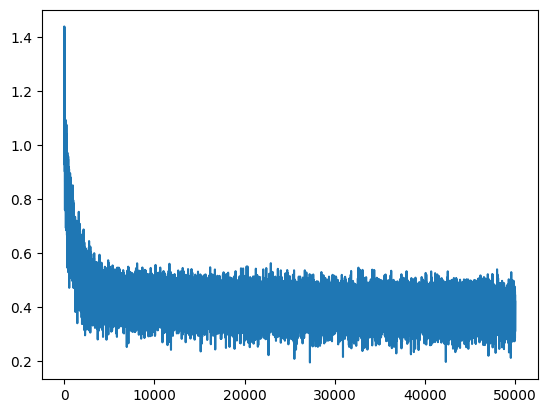

In [224]:
plt.plot(steps, loss)

the line got thicker because there are lot of fluctuations b/c of minibatches, one way to improve the gradient/model is to increase the batch size so that we get good loss without crazy fluctuations

In [226]:
# let's train more
steps, loss = train(50000, 32, 0.01)    # decay lr
calc_overall_loss()

2.307107925415039


In [227]:
calc_overall_loss(x_tr, y_tr)

2.29162335395813


improved from the prev model 🥳

so increasing the embed dimension worked

In [231]:
# let's train more
steps, loss = train(50000, 32, 0.01)
calc_overall_loss()

2.306823492050171


In [232]:
calc_overall_loss(x_tr, y_tr)

2.289712429046631


we can see our dev and train loss is starting to diverge a bit

In [233]:
# let's train more
steps, loss = train(50000, 32, 0.01)
calc_overall_loss()

2.3027825355529785


In [234]:
calc_overall_loss(x_tr, y_tr)

2.2806904315948486


Many ways to continue improving the model - 

1) increase the hidden layer size

2) increase the embedding dimension

3) increase the context length

4) increase batch size for efficient training times/gradient steps

5) try more lrs and lr decays 

etc ....

## inference

In [243]:
torch.save({"emb": C, "w1": W1, "b1": b1, "w2": W2, "b2": b2}, "mlp.pt")

In [244]:
mlp_layers = torch.load("mlp.pt")

In [240]:
g = torch.Generator().manual_seed(SEED)
n = 10
block_size = 3
for _ in range(n):  # predict n words
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)        # create batch_size 1
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itoc[i] for i in out))
    

anu.
den.
tis.
maridu.
davmubunderlayan.
cottah.
lavan.
epindenden.
diza.
kumar.


In [248]:
c, w1, b1, w2, b2 = mlp_layers["emb"], mlp_layers['w1'], mlp_layers['b1'], mlp_layers['w2'], mlp_layers['b2']

In [249]:
g = torch.Generator().manual_seed(SEED)
n = 10
block_size = 3
for _ in range(n):  # predict n words
    out = []
    context = [0]*block_size
    while True:
        emb = c[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ w1 + b1)        # create batch_size 1
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itoc[i] for i in out))
    

anu.
den.
tis.
maridu.
davmubunderlayan.
cottah.
lavan.
epindenden.
diza.
kumar.
